In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

def construct_kernels_centralnode(fileinput,els,kernels_s,kernels_n,traction_kernels_s,traction_kernels_n, matrix_slip):
    
    bctype_x = fileinput["bc_type_x"].values
    bctype_y = fileinput["bc_type_y"].values
    labels = fileinput["collection"].values
    
    n_els = len(els.x1)
    Nunknowns = 6 * n_els

    # Linear operator for central node BCs
    kerneleval_x = np.zeros((n_els, Nunknowns))
    kerneleval_y = np.zeros((n_els, Nunknowns))

    # x,y-kernels
    for i in np.unique(labels):
        index = np.where(labels == i)[0]
        for j in index:
            if bctype_x[j] == "u_global":
                for k in range(0, 3):
                    kerneleval_x[j, k::6] = kernels_s[3][j, k::3]
                    kerneleval_x[j, k + 3 :: 6] = kernels_n[3][j, k::3]
            elif bctype_x[j] == "t_local":
                for k in range(0, 3):
                    kerneleval_x[j, k::6] = traction_kernels_s[0][j, k::3]
                    kerneleval_x[j, k + 3 :: 6] = traction_kernels_n[0][j, k::3]
            elif bctype_x[j] == "s_local":
                kerneleval_x[j, :] = matrix_slip[2::6, :][j, :]
            else:
                raise ValueError("unrecognized boundary condition type")

            if bctype_y[j] == "u_global":
                for k in range(0, 3):
                    kerneleval_y[j, k::6] = kernels_s[4][j, k::3]
                    kerneleval_y[j, k + 3 :: 6] = kernels_n[4][j, k::3]
            elif bctype_y[j] == "t_local":
                for k in range(0, 3):
                    kerneleval_y[j, k::6] = traction_kernels_s[1][j, k::3]
                    kerneleval_y[j, k + 3 :: 6] = traction_kernels_n[1][j, k::3]
            elif bctype_y[j] == "s_local":
                kerneleval_y[j, :] = matrix_slip[3::6, :][j, :]
            else:
                raise ValueError("unrecognized boundary condition type")
            
    return kerneleval_x,kerneleval_y

def extract_quadratic_components(quadratic_coefs,n_els):
    # extract (s,n) components and store them in 2 separate vectors
    quadratic_coefs_s = np.zeros((3 * n_els, 1))
    quadratic_coefs_n = np.zeros((3 * n_els, 1))
    for i in range(n_els):
        quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
        quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]
    
    return quadratic_coefs_s,quadratic_coefs_n


## Main Himalayan Thrust BEM experiment
In this numerical experiment we construct a model of the 2015 Gorkha earthquake that had 4-6 m of coseismic slip along the deeper "flat" structure of the MHT. We compare a traditional constant slip BEM approach with solutions using our new "smooth slip" formulation (`bemcs`)

Going from the quadratic basis function formulation in `bemcs` to constant basis is simple. We take the kernels that we constructed for the quadratic nodes and sum each of the 3 kernel partials to get the constant kernel. Note that these kernels can be either 'slip', 'displacement' or 'traction' kernels. 

In practice, if the quadratic kernel is of the form for 2 fault elements $a$ and $b$:

$K_q = \begin{bmatrix} 
\phi^s_{a1} & \phi^s_{a2} & \phi^s_{a3} & \phi^n_{a1} & \phi^n_{a2} & \phi^n_{a3} & 
\phi^s_{b1} & \phi^s_{b2} & \phi^s_{b3} & \phi^n_{b1} & \phi^n_{b2} & \phi^n_{b3} & ... \\ 
\vdots & & & \vdots & & & \vdots & & & \vdots & & & ...
\end{bmatrix}$

then the constant slip kernel $K_c$ can be computes as:

$K_c = \begin{bmatrix}
\phi^s_{a1} + \phi^s_{a2} + \phi^s_{a3} & \phi^n_{a1} + \phi^n_{a2} + \phi^n_{a3} & 
\phi^s_{b1} + \phi^s_{b2} + \phi^s_{b3} & \phi^n_{b1} + \phi^n_{b2} + \phi^n_{b3} & ... \\
\vdots & \vdots & \vdots & \vdots & ...
\end{bmatrix}$


['left_topo' 'mbt' 'ramp_mft' 'right_edge' 'right_topo' 'topo']


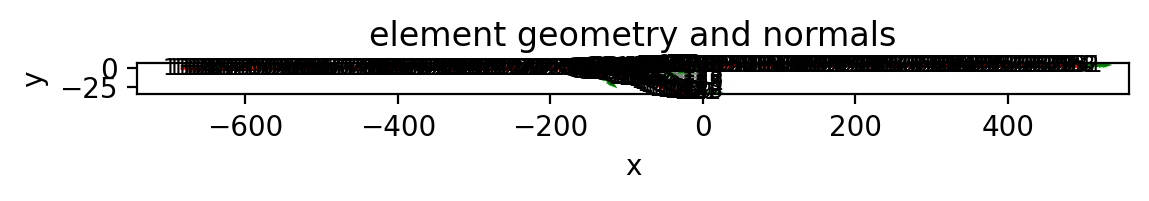

'# Observation points INSIDE the bulk medium (for visualization)\nnx_obs = 100\nny_obs = 10\nx_obs = np.linspace(-200, 10, nx_obs)\ny_obs = np.linspace(-33, 6, ny_obs)\nx_obs, y_obs = np.meshgrid(x_obs, y_obs)\nxint_obs = x_obs.flatten()\nyint_obs = y_obs.flatten()\n\n# Compute shear and tensile stress kernels for observation points INSIDE the bulk medium\nkernels_obs_s = bemcs.get_displacement_stress_kernel(\n    xint_obs, yint_obs, els, mu, nu, "shear"\n)\nkernels_obs_n = bemcs.get_displacement_stress_kernel(\n    xint_obs, yint_obs, els, mu, nu, "normal"\n)'

In [2]:
# Elastic parameters
mu = 1
nu = 0.25

# read fault geometry files
fileinput = pd.read_csv("mht_geometry_gorkha_5_km.csv")
# fileinput = pd.read_csv("mht_geometry_bcnew_5_km.csv")


# print(fileinput.head())
x1 = fileinput["x1"].values
x2 = fileinput["x2"].values
y1 = fileinput["y1"].values
y2 = fileinput["y2"].values
bc_x = fileinput["bc_x"].values
bc_y = fileinput["bc_y"].values
bctype_x = fileinput["bc_type_x"].values
bctype_y = fileinput["bc_type_y"].values

labels = fileinput["collection"].values
print(np.unique(labels))

# create bemcs data structure
els = bemcs.initialize_els()
els.x1 = x1
els.y1 = y1
els.x2 = x2
els.y2 = y2
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
faultid = np.arange(n_els)
bemcs.plot_els_geometry(els)

"""# Observation points INSIDE the bulk medium (for visualization)
nx_obs = 100
ny_obs = 10
x_obs = np.linspace(-200, 10, nx_obs)
y_obs = np.linspace(-33, 6, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xint_obs = x_obs.flatten()
yint_obs = y_obs.flatten()

# Compute shear and tensile stress kernels for observation points INSIDE the bulk medium
kernels_obs_s = bemcs.get_displacement_stress_kernel(
    xint_obs, yint_obs, els, mu, nu, "shear"
)
kernels_obs_n = bemcs.get_displacement_stress_kernel(
    xint_obs, yint_obs, els, mu, nu, "normal"
)"""

## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [3]:
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# apply BCs at central nodes
BC_c[0::2, 0] = bc_x
BC_c[1::2, 0] = bc_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

Number of open nodes = 2
: [array([393]), array([695])]
Number of 2-overlap nodes = 324
: [array([ 396, -395]), array([ 399, -398]), array([ 402, -401]), array([ 405, -404]), array([ 408, -407]), array([ 411, -410]), array([ 414, -413]), array([ 417, -416]), array([ 420, -419]), array([ 423, -422]), array([ 426, -425]), array([ 429, -428]), array([ 432, -431]), array([ 435, -434]), array([ 438, -437]), array([ 441, -440]), array([ 444, -443]), array([ 447, -446]), array([ 450, -449]), array([ 453, -452]), array([ 456, -455]), array([ 459, -458]), array([ 462, -461]), array([ 465, -464]), array([ 468, -467]), array([ 471, -470]), array([ 474, -473]), array([ 477, -476]), array([ 480, -479]), array([ 483, -482]), array([ 486, -485]), array([ 489, -488]), array([ 492, -491]), array([ 495, -494]), array([ 498, -497]), array([ 501, -500]), array([ 504, -503]), array([ 507, -506]), array([ 510, -509]), array([ 513, -512]), array([ 516, -515]), array([ 519, -518]), array([ 522, -521]), array(

### Design Matrix System 
- At element centers, we implement either displacement, slip or traction boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we implement 2 equations for conservation of slip and 4 equations for smoothness


In [4]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, reference="local"
)

# Patch center locations
# (need to be shifted an infinitesimal amount in unit normal direction for displacement bcs)
epsilonr = 1e-6 * (bctype_x == "u_global").astype(float)
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = (obs_xy[:, 0] + epsilonr * els.x_normals).reshape(-1, 1)
y_obs = (obs_xy[:, 1] + epsilonr * els.y_normals).reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="local")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="local")

/Users/meade/Desktop/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:150: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))


## Construct linear operator and solve system

In [5]:
# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))

kerneleval_x, kerneleval_y = construct_kernels_centralnode(
    fileinput,
    els,
    kernels_s,
    kernels_n,
    traction_kernels_s,
    traction_kernels_n,
    matrix_slip,
)

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

Linear Operator Condition Number: 30600.925532251636


## Solve for same system using constant slip formulation

Unlike the previous formulation where we needed boundary conditions at central nodes and then we imposed continuity and differentiability as boudary conditions on shared nodes, here we implement a $C_0$ mesh i.e., every mesh element (and its coefficients) is independent of other elements. This is the traditional method used in the BEM literature.

Constant slip kernel $K_c$ can be constructed by summing the appropriate columns of the relevant quadratic kernel $K_q$ as follows:

$K_c = \begin{bmatrix}
\phi^s_{a1} + \phi^s_{a2} + \phi^s_{a3} & \phi^n_{a1} + \phi^n_{a2} + \phi^n_{a3} & 
\phi^s_{b1} + \phi^s_{b2} + \phi^s_{b3} & \phi^n_{b1} + \phi^n_{b2} + \phi^n_{b3} & ... \\
\vdots & \vdots & \vdots & \vdots & ...
\end{bmatrix}$

In [6]:
# provide new input file for locked system with appropriate BCs
bc_x = fileinput["bc_x"].values
bc_y = fileinput["bc_y"].values
BC_c[0::2, 0] = bc_x
BC_c[1::2, 0] = bc_y

# Linear Operators for the appropriate boundary conditions
# note that we now only need to evaluate BCs at the center of each node, so the size of the operator is smaller than before
matrix_system_c = np.zeros((N_c, N_c))
kernelconst_x = np.zeros((n_els, N_c))
kernelconst_y = np.zeros((n_els, N_c))

# to construct a constant slip kernel, simply sum the 3 quadratic terms i.e., each set of 3 columns from the original kernels
for i in range(N_c):
    kernelconst_x[:, i] = np.sum(kerneleval_x[:, i * 3 : 3 * (i + 1)], axis=1)
    kernelconst_y[:, i] = np.sum(kerneleval_y[:, i * 3 : 3 * (i + 1)], axis=1)

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kernelconst_x
matrix_system_c[1::2, :] = kernelconst_y

# compute quadratic node coefficients (in local (s,n) coordinates)
constant_coefs = np.linalg.inv(matrix_system_c) @ BC_c
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system_c))

Linear Operator Condition Number: 1083.061156110585


/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_32424/994557190.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(matrix_system_c)))


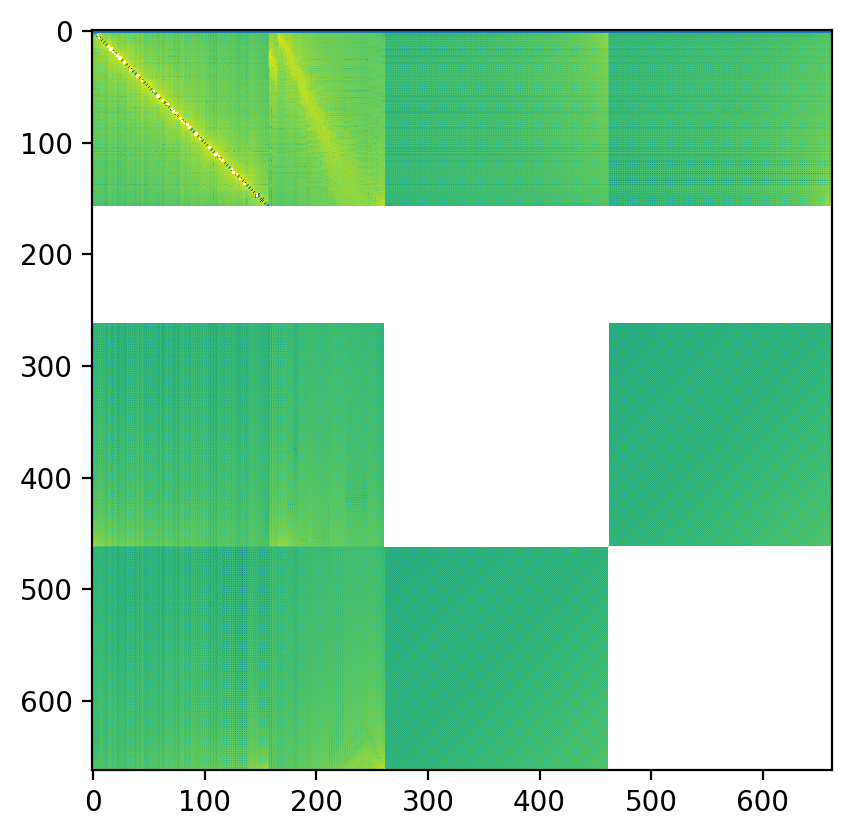

In [17]:
plt.plot(BC_c)
plt.imshow(np.log10(np.abs(matrix_system_c)))

## Plot slip on all fault nodes

Here we plot slip from the "smooth slip" formulation and the "constant slip" formulations side-by-side to show the solutions are generally convergent. The major difference is when one tries to compute stress changes near the faults

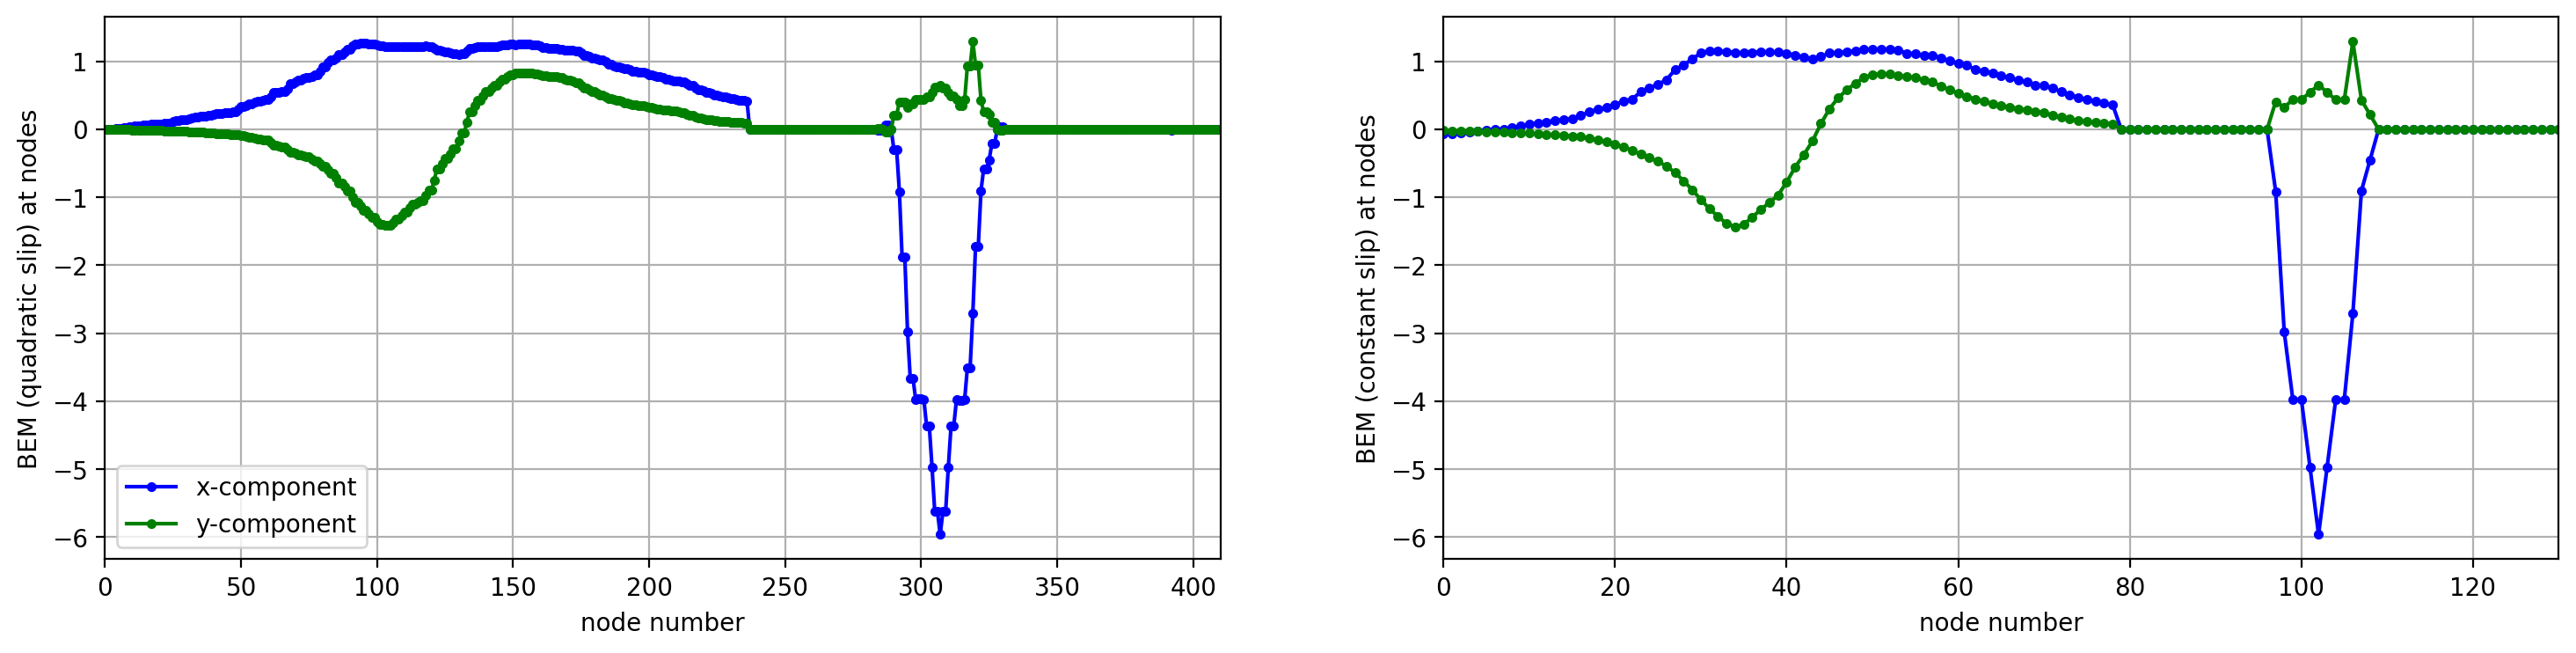

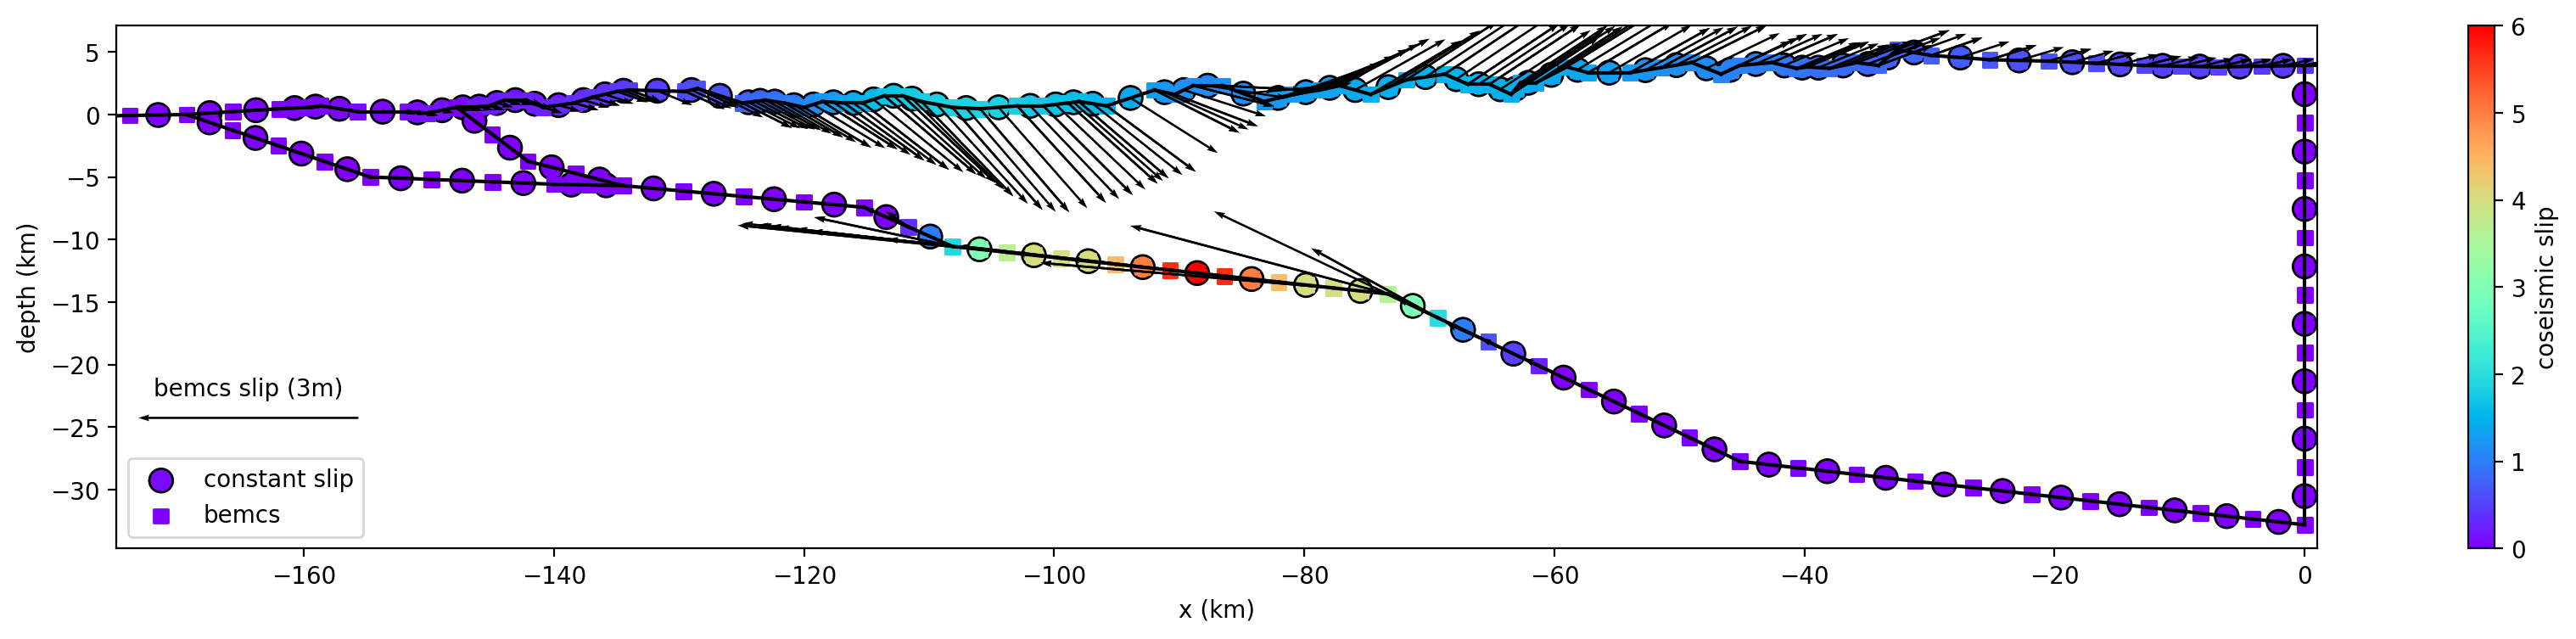

In [7]:
# Extract slip at nodes from quadratic coefficients
matrix_slip, _ = bemcs.get_matrices_slip_slip_gradient(els, reference="global")

# plot interseismic slip rate distribution
slip_nodes = matrix_slip @ (quadratic_coefs)
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x, slip_nodes_y))
xnodes = np.zeros((3 * n_els, 1))
ynodes = np.zeros((3 * n_els, 1))
xnodes[0::3, 0] = els.x1
xnodes[2::3, 0] = els.x2
xnodes[1::3, 0] = els.x_centers
ynodes[0::3, 0] = els.y1
ynodes[2::3, 0] = els.y2
ynodes[1::3, 0] = els.y_centers

plt.figure(figsize=(18, 4))
plt.subplot(1, 2, 1)
plt.plot(slip_nodes_x, "b.-", label="x-component")
plt.plot(slip_nodes_y, "g.-", label="y-component")
plt.xlabel("node number")
plt.ylabel("BEM (quadratic slip) at nodes")
plt.legend()
plt.grid()
plt.xlim(0, 410)

plt.subplot(1, 2, 2)
# rotate constant slip coefficients from (s,n) to (x,y) cordinates
constant_slip_s = constant_coefs[0::2, 0]
constant_slip_n = constant_coefs[1::2, 0]
constant_slip_x = np.zeros_like(constant_slip_s)
constant_slip_y = np.zeros_like(constant_slip_s)
slip_vector = np.vstack((constant_slip_s, constant_slip_n)).T
for i in range(n_els):
    constant_slip_x[i], constant_slip_y[i] = (
        slip_vector[i, :] @ els.rot_mats_inv[i, :, :]
    )
plt.plot(constant_slip_x, "b.-", label="x-component")
plt.plot(constant_slip_y, "g.-", label="y-component")
plt.xlabel("node number")
plt.ylabel("BEM (constant slip) at nodes")
plt.grid()
plt.xlim(0, 130)
plt.show()

plt.figure(figsize=(23, 4))
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.scatter(
    els.x_centers,
    els.y_centers,
    c=np.sqrt(constant_slip_x**2 + constant_slip_y**2),
    s=100,
    label="constant slip",
    marker="o",
    cmap="rainbow",
    edgecolors="k",
)
plt.scatter(
    xnodes,
    ynodes,
    c=np.sqrt(slip_nodes_x**2 + slip_nodes_y**2),
    label="bemcs",
    marker="s",
    cmap="rainbow",
)
plt.colorbar(label="coseismic slip")
q = plt.quiver(
    xnodes,
    ynodes,
    slip_nodes_x,
    slip_nodes_y,
    scale=30,
    width=0.001,
)
plt.quiverkey(q, X=0.06, Y=0.25, U=-3, label="bemcs slip (3m)", labelpos="N")
plt.xlim([-175, 1])
plt.xlabel("x (km)")
plt.ylabel("depth (km)")
plt.legend()
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# Attempt internal evaluation for constant slip case

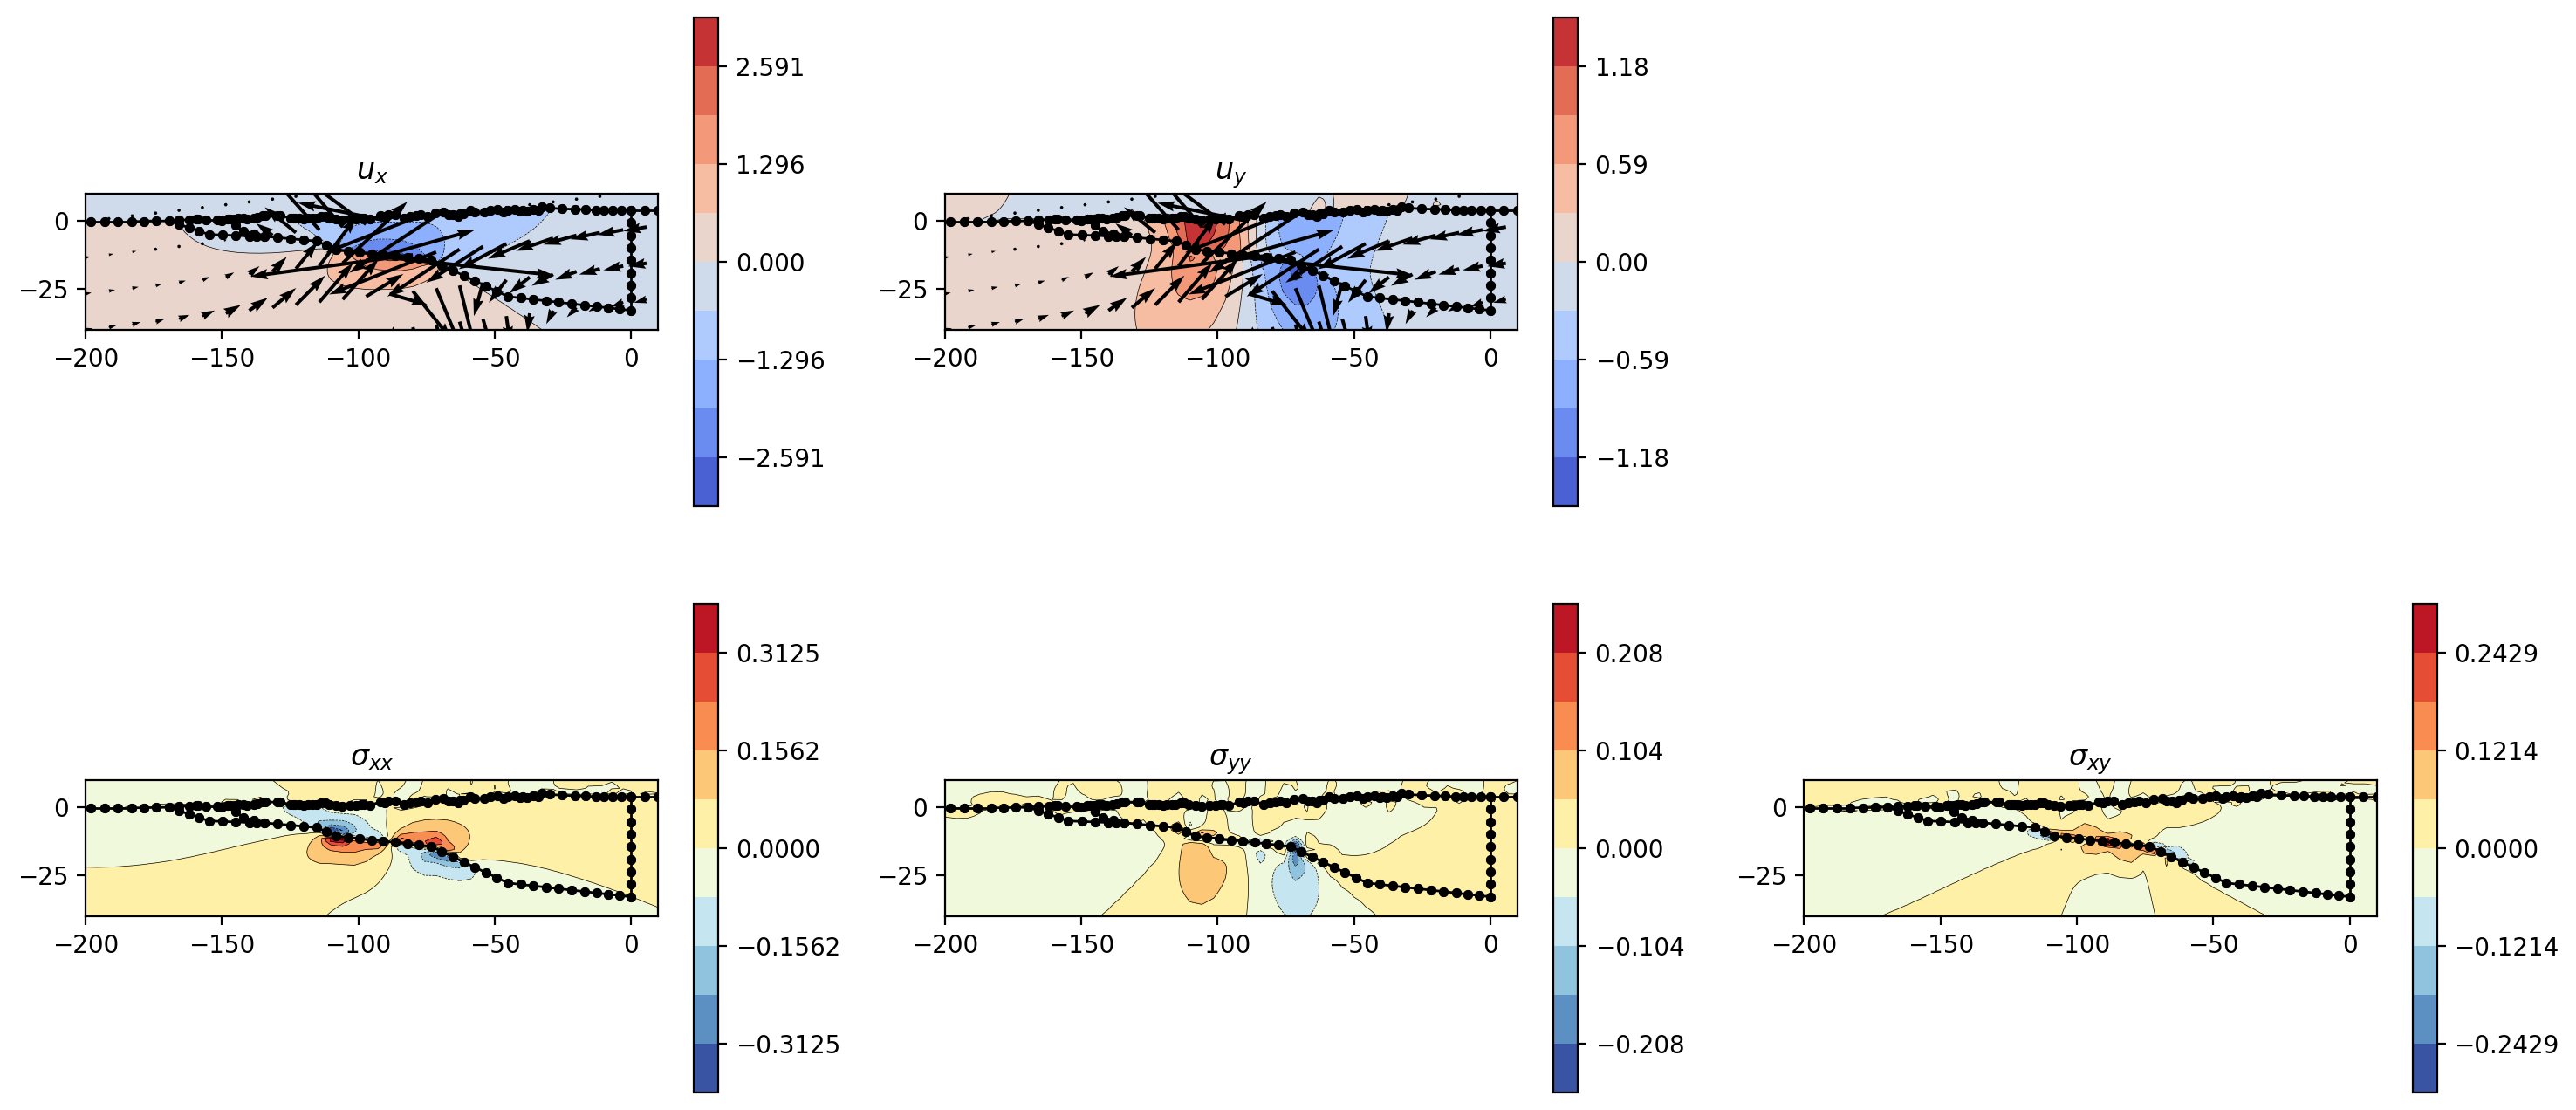

conversion='plane_strain'
[[ 0.375 -0.125  0.   ]
 [-0.125  0.375  0.   ]
 [ 0.     0.     1.   ]]
conversion='plane_stress'
[[ 0.4 -0.1  0. ]
 [-0.1  0.4  0. ]
 [ 0.   0.   1. ]]


In [8]:
# Observation points
n_obs = 50
x_obs = np.linspace(-200, 10, n_obs)
y_obs = np.linspace(-40, 10, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Take constant slip state vector and create quadratic vector with copied constant_coefs values
quadratic_coefs = np.zeros((6 * n_els, 1))
quadratic_coefs[0::3] = constant_coefs
quadratic_coefs[1::3] = constant_coefs
quadratic_coefs[2::3] = constant_coefs

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

# Compute displacement and stresses (we will plot it later)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=26
)

strain_energy_plane_strain = bemcs.get_strain_from_stress(
    sxx, syy, sxy, mu, nu, conversion="plane_strain"
)
strain_energy_plane_stress = bemcs.get_strain_from_stress(
    sxx, syy, sxy, mu, nu, conversion="plane_stress"
)

In [9]:
df = pd.read_csv("mht_wedge_polygon.csv")
inpolygon_vals = bemcs.inpolygon(
    x_obs.flatten(), y_obs.flatten(), df.x.values, df.y.values
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_obs, n_obs))

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_32424/3540086817.py:24: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(


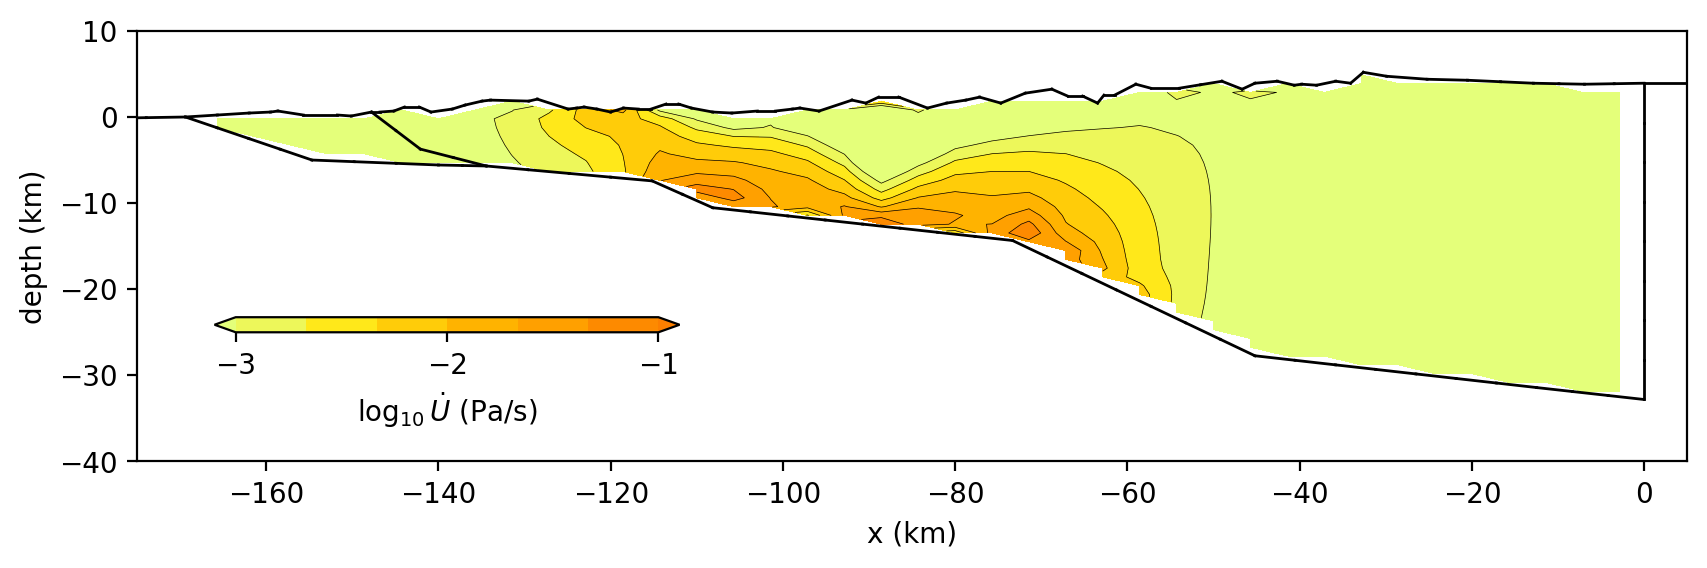

In [10]:
plt.figure(figsize=(10, 5))
# toplot = np.sqrt(ux.reshape(n_obs, n_obs) ** 2 + uy.reshape(n_obs, n_obs) ** 2)
toplot = strain_energy_plane_strain.reshape(n_obs, n_obs)
toplot = np.log10(toplot)
toplot[~inpolygon_vals] = np.nan

levels = np.linspace(0, 7, 21)
levels = np.linspace(-3, -1, 7)

plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="Wistia",
    extend="both",
    levels=levels,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.05, 0.30, 0.3, 0.035)),
    orientation="horizontal",
    label="$\log_{10} \dot{U}$ (Pa/s)",
)
cb.set_ticks([-3, -2, -1])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    linewidths=0.25,
    colors="k",
    levels=levels,
    linestyles="-",
    linewidth=0.25,
)

for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-", linewidth=1.0)
# for i in range(n_els):
#     plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "w-", linewidth=1.0)

plt.xlim([-175, 5])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x (km)")
plt.ylabel("depth (km)")
plt.savefig("mht_internal_strain_energy_constant.png", dpi=500)
plt.savefig("mht_internal_strain_energy_constant.pdf")
plt.show()

# Plot second stress invariant

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_32424/3076322507.py:24: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(


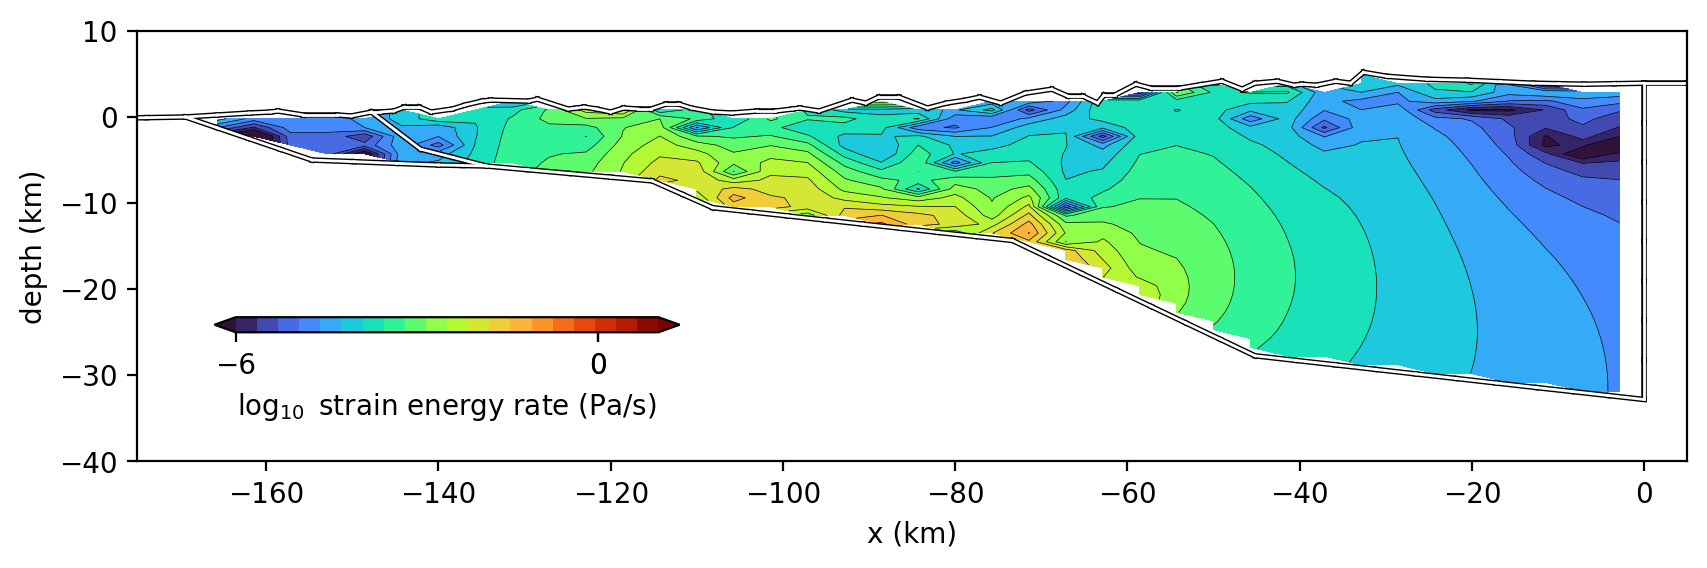

In [11]:
plt.figure(figsize=(10, 5))
# toplot = np.sqrt(ux.reshape(n_obs, n_obs) ** 2 + uy.reshape(n_obs, n_obs) ** 2)
# toplot = strain_energy_plane_strain.reshape(n_obs, n_obs)
toplot = np.log10(np.abs(sxx * syy - sxy**2)).reshape(n_obs, n_obs)
toplot[~inpolygon_vals] = np.nan

levels = np.linspace(0, 7, 21)
levels = np.linspace(-6, 1, 21)

plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="turbo",
    extend="both",
    levels=levels,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.05, 0.30, 0.3, 0.035)),
    orientation="horizontal",
    label="$\log_{10}$ strain energy rate (Pa/s)",
)
cb.set_ticks([-6, 0, 0])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    linewidths=0.25,
    colors="k",
    levels=levels,
    linestyles="-",
    linewidth=0.25,
)

for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-", linewidth=2.0)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "w-", linewidth=1.0)

plt.xlim([-175, 5])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x (km)")
plt.ylabel("depth (km)")
# plt.savefig("mht_internal_strain_energy.png", dpi=500)
# plt.savefig("mht_internal_strain_energy.pdf")
plt.show()

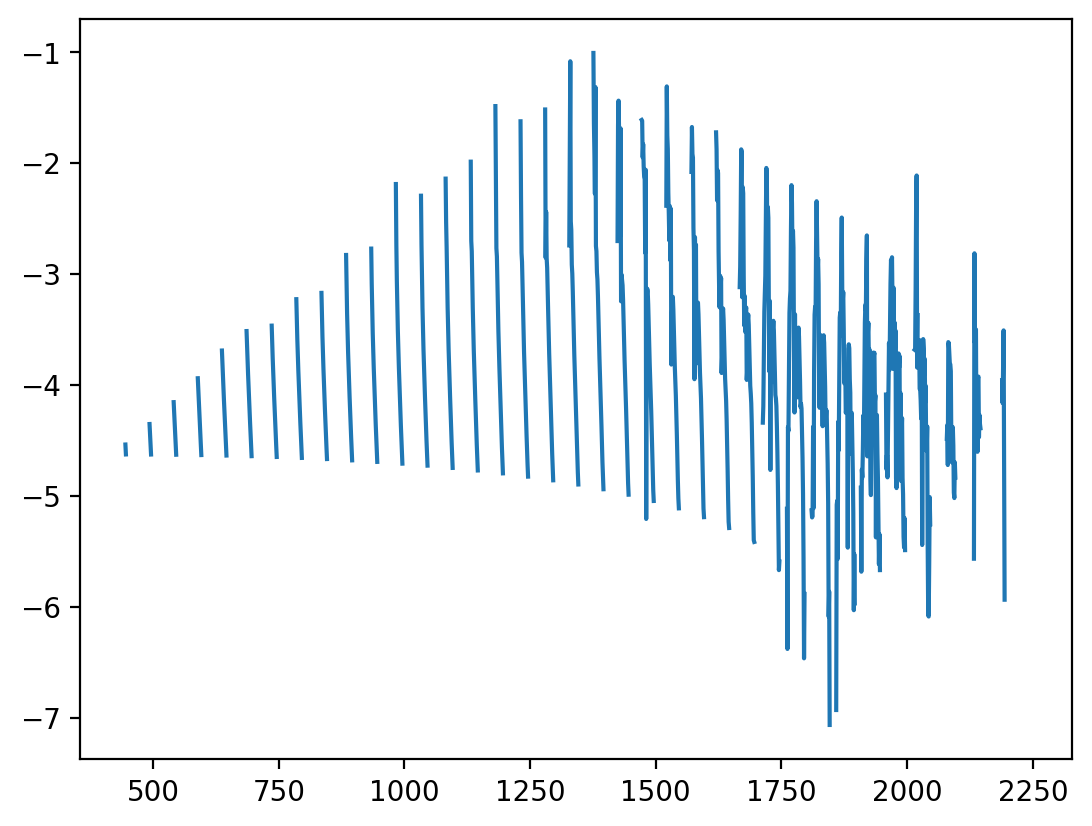

In [12]:
plt.plot(toplot.flatten())

# Plot first stress invariant

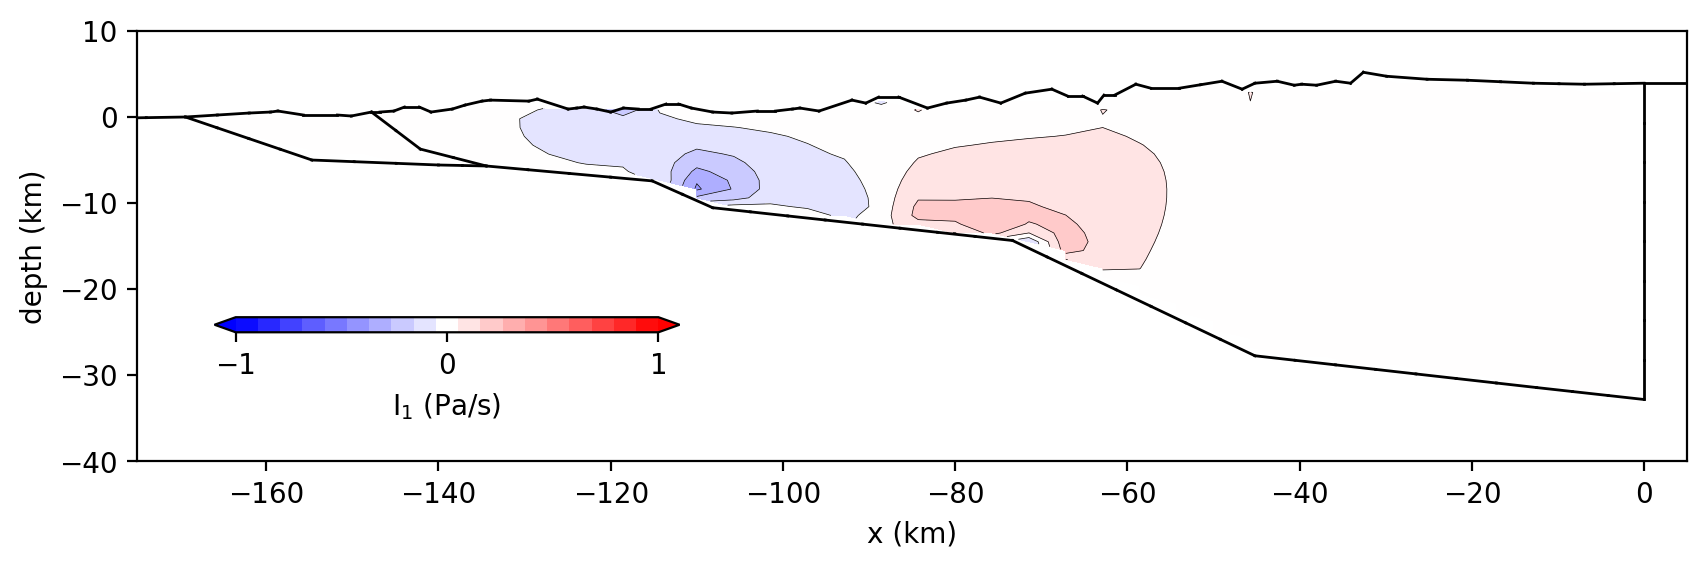

In [13]:
plt.figure(figsize=(10, 5))
# toplot = np.sqrt(ux.reshape(n_obs, n_obs) ** 2 + uy.reshape(n_obs, n_obs) ** 2)
# toplot = strain_energy_plane_strain.reshape(n_obs, n_obs)
toplot = (sxx + syy).reshape(n_obs, n_obs)
# toplot = np.log10(np.abs(sxx * syy - sxy**2)).reshape(n_obs, n_obs)

toplot[~inpolygon_vals] = np.nan

levels = np.linspace(0, 7, 21)
levels = np.linspace(-1.0, 1.0, 20)

plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="bwr",
    extend="both",
    levels=levels,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.05, 0.30, 0.3, 0.035)),
    orientation="horizontal",
    label="$\mathrm{I}_{1}$ (Pa/s)",
)
cb.set_ticks([-1, 0, 1])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    linewidths=0.25,
    colors="k",
    levels=levels,
    linestyles="-",
)

for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-", linewidth=1.0)
# for i in range(n_els):
#     plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "w-", linewidth=1.0)

plt.xlim([-175, 5])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x (km)")
plt.ylabel("depth (km)")
plt.savefig("mht_internal_I1_constant.png", dpi=500)
plt.savefig("mht_internal_I1_constant.pdf")
plt.show()